학습목표<br>
다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.<br>
gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.<br>
한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.<br>
<br>
평가기준<br>
3가지 이상의 모델이 성공적으로 시도됨<br>
gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함<br>
네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함<br>

!pip install konlpy

!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash ./Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh

!pip install gensim==4.3.2
!pip install scipy==1.12.0 numpy==1.26.3

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

2.3.0
0.6.0
4.3.2


# 1) 데이터 준비와 확인

In [2]:
import pandas as pd
import os

# 데이터를 읽어봅시다.
train_data = pd.read_table(os.getenv("HOME") + '/work/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table(os.getenv("HOME") + '/work/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.<br>

데이터의 중복 제거<br>
NaN 결측치 제거<br>
한국어 토크나이저로 토큰화<br>
불용어(Stopwords) 제거<br>
사전word_to_index 구성<br>
텍스트 스트링을 사전 인덱스 스트링으로 변환<br>
X_train, y_train, X_test, y_test, word_to_index 리턴<br>

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_test.append(temp_x)

    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델구성을 위한 데이터 분석 및 가공
데이터셋 내 문장 길이 분포<br>
적절한 최대 문장 길이 지정<br>
torch.nn.utils.rnn.pad_swquence 를 활용한 패딩 추가<br>

In [6]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[32, 74, 939, 4, 4, 39, 229, 20, 33, 747]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [7]:
print(get_decoded_sentence(x_train[0], index_to_word))

더 빙 . . 진짜 짜증 나 네요 목소리


In [8]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)*100}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.971019612059036
문장길이 최대 :  116
문장길이 표준편차 :  12.844062009473816
pad_sequences maxlen :  41
전체 문장의 93.42629991962691%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
import torch

def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            pad = [0] * (maxlen - len(sentence))
            #sentence = sentence + pad        # ← 뒤쪽에 0을 붙임
            sentence = pad + sentence        # ← 앞쪽에 0을 붙임
        else:
            sentence = sentence[:maxlen]     # ← 기존 그대로(뒤쪽 자르기)
        padded_data.append(sentence)
    return np.array(padded_data)

    

x_train_padded = pad_sequences(x_train, maxlen)
x_test_padded = pad_sequences(x_test, maxlen)

x_train_tensor = torch.tensor(x_train_padded, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)

print(x_train_tensor.shape)

torch.Size([146182, 41])


# 4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)
        self.fc1 = nn.Linear(8, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
        
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
model = SentimentModel(vocab_size, word_vector_dim)
print(model)

SentimentModel(
  (embedding): Embedding(10000, 16)
  (lstm): LSTM(16, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [11]:
class CNN(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.conv1 = nn.Conv1d(word_vector_dim, 16, kernel_size=7)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=7)
        self.pool = nn.MaxPool1d(5)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
model = CNN(vocab_size, word_vector_dim)

print(model)

CNN(
  (embedding): Embedding(10000, 16)
  (conv1): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [12]:
class GMP1D(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(GMP1D, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(word_vector_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
model = GMP1D(vocab_size, word_vector_dim)

print(model)

GMP1D(
  (embedding): Embedding(10000, 16)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [13]:
# validation set 10000건 분리
x_val = x_train_tensor[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_x_train = x_train_tensor[10:]
partial_y_train = y_train[10:]

print(partial_x_train.shape)
print(partial_y_train.shape)

torch.Size([146172, 41])
(146172,)


# 5) 모델 훈련 개시
# 6) Loss, Accuracy 그래픽 시각화
# 7) 학습된 Embedding 레이어 분석

Model:  SentimentModel


/tmp/ipykernel_10719/1367059206.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipykernel_10719/1367059206.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


#=========================================================
모델 훈련
#==========
Epoch 1/15 - Train Loss: 0.6437, Train Accuracy: 0.6205 - Validation Loss: 0.5498, Validation Accuracy: 0.7293
Epoch 2/15 - Train Loss: 0.4949, Train Accuracy: 0.7633 - Validation Loss: 0.4439, Validation Accuracy: 0.7948
Epoch 3/15 - Train Loss: 0.4268, Train Accuracy: 0.8060 - Validation Loss: 0.3952, Validation Accuracy: 0.8230
Epoch 4/15 - Train Loss: 0.3901, Train Accuracy: 0.8274 - Validation Loss: 0.3681, Validation Accuracy: 0.8392
Epoch 5/15 - Train Loss: 0.3667, Train Accuracy: 0.8399 - Validation Loss: 0.3482, Validation Accuracy: 0.8458
Epoch 6/15 - Train Loss: 0.3499, Train Accuracy: 0.8487 - Validation Loss: 0.3306, Validation Accuracy: 0.8576
Epoch 7/15 - Train Loss: 0.3380, Train Accuracy: 0.8539 - Validation Loss: 0.3231, Validation Accuracy: 0.8611
Epoch 8/15 - Train Loss: 0.3270, Train Accuracy: 0.8607 - Validation Loss: 0.3102, Validation Accuracy: 0.8678
Epoch 9/15 - Train Loss: 0.3183, Tr

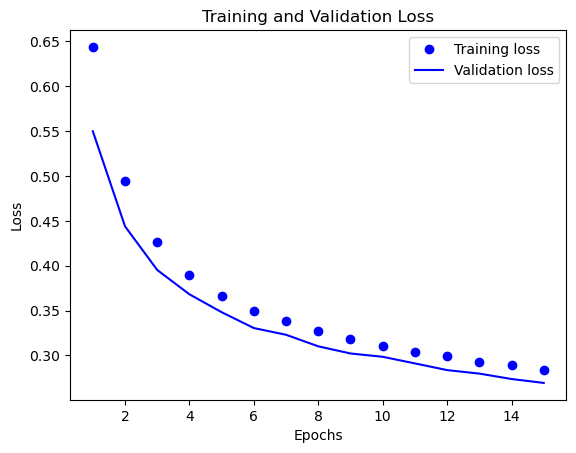

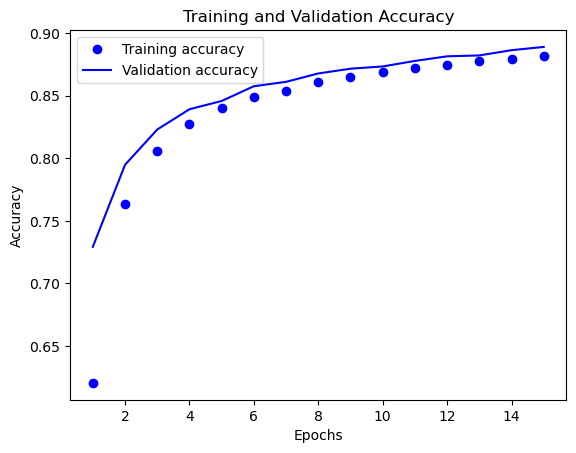

#=========================================================
학습된 Embedding 레이어 분석
#==========
(10000, 16)
size(word_vectors)= (9996, 16)
word_vectors[음악]:
[ 0.4855116   2.0462751   2.3392863   1.5831299  -1.1575344  -0.4080122
 -0.0675635   0.8369047   0.03802291 -0.880998    1.1411072   0.19873802
 -0.69781446 -0.6010231   0.55014896  0.4414601 ]
similar_by_word(음악)
[('능가', 0.7901811599731445), ('^^', 0.7748043537139893), ('전도연', 0.7622754573822021), ('원장', 0.745826244354248), ('롤', 0.7271344065666199), ('겻', 0.7199417948722839), ('본질', 0.7129358053207397), ('따윈', 0.7036566734313965), ('부패', 0.6924392580986023), ('못하', 0.6905930638313293)]
Model:  CNN
#=========================================================
모델 훈련
#==========


/tmp/ipykernel_10719/1367059206.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipykernel_10719/1367059206.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


Epoch 1/15 - Train Loss: 0.6191, Train Accuracy: 0.6435 - Validation Loss: 0.5290, Validation Accuracy: 0.7381
Epoch 2/15 - Train Loss: 0.4950, Train Accuracy: 0.7577 - Validation Loss: 0.4523, Validation Accuracy: 0.7879
Epoch 3/15 - Train Loss: 0.4347, Train Accuracy: 0.7973 - Validation Loss: 0.4024, Validation Accuracy: 0.8176
Epoch 4/15 - Train Loss: 0.3979, Train Accuracy: 0.8193 - Validation Loss: 0.3754, Validation Accuracy: 0.8320
Epoch 5/15 - Train Loss: 0.3738, Train Accuracy: 0.8333 - Validation Loss: 0.3523, Validation Accuracy: 0.8415
Epoch 6/15 - Train Loss: 0.3562, Train Accuracy: 0.8436 - Validation Loss: 0.3382, Validation Accuracy: 0.8501
Epoch 7/15 - Train Loss: 0.3425, Train Accuracy: 0.8508 - Validation Loss: 0.3258, Validation Accuracy: 0.8577
Epoch 8/15 - Train Loss: 0.3321, Train Accuracy: 0.8565 - Validation Loss: 0.3153, Validation Accuracy: 0.8646
Epoch 9/15 - Train Loss: 0.3221, Train Accuracy: 0.8621 - Validation Loss: 0.3066, Validation Accuracy: 0.8689
E

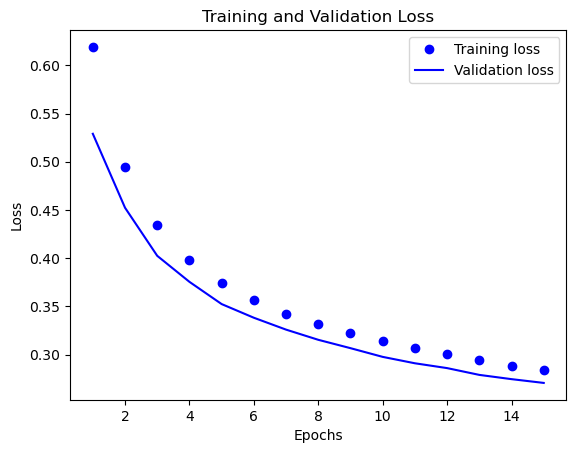

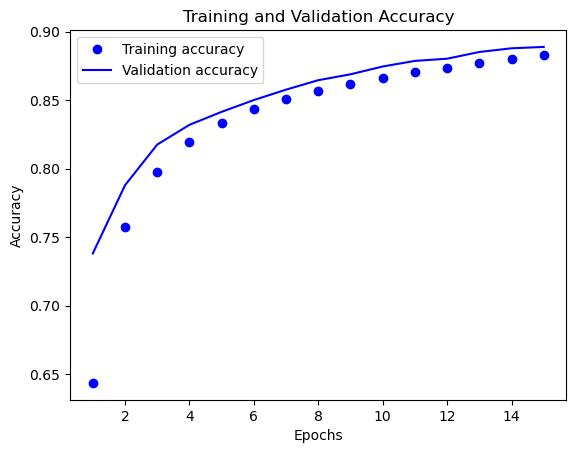

#=========================================================
학습된 Embedding 레이어 분석
#==========
(10000, 16)
size(word_vectors)= (9996, 16)
word_vectors[음악]:
[ 0.9588436   0.9077303  -2.0582142   0.19356774 -0.5919076   1.4271425
 -0.2699855   0.7833645   0.92772675 -0.9682969   1.471245   -0.11698548
  0.96394765 -0.99723536  0.18847266  0.11767041]
similar_by_word(음악)
[('어메이징', 0.8687040209770203), ('오리지널', 0.8057399392127991), ('자꾸', 0.7656567096710205), ('찐한', 0.7601895928382874), ('내게는', 0.7585742473602295), ('판사', 0.7408507466316223), ('큼', 0.7396174669265747), ('요거', 0.729453980922699), ('수애', 0.7208852767944336), ('케빈', 0.7174208760261536)]
Model:  GMP1D
#=========================================================
모델 훈련
#==========
Epoch 1/15 - Train Loss: 0.6841, Train Accuracy: 0.5617 - Validation Loss: 0.6632, Validation Accuracy: 0.6197
Epoch 2/15 - Train Loss: 0.6123, Train Accuracy: 0.6701 - Validation Loss: 0.5601, Validation Accuracy: 0.7088
Epoch 3/15 - Train Loss: 0.5278, Tr

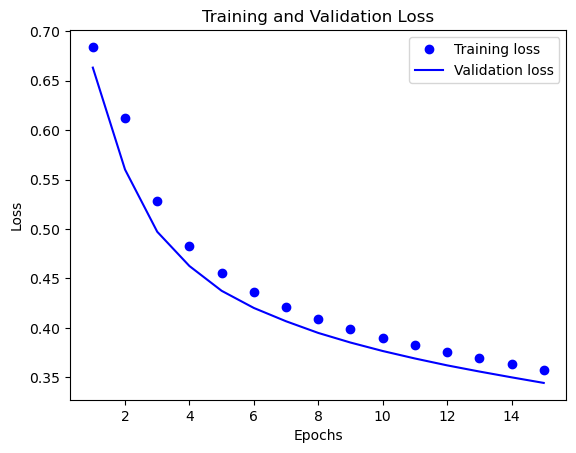

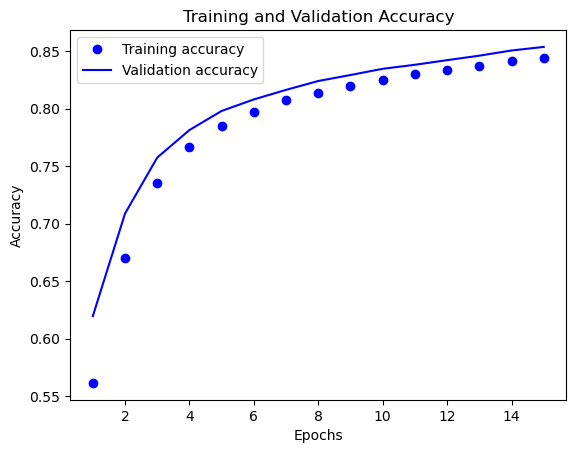

#=========================================================
학습된 Embedding 레이어 분석
#==========
(10000, 16)
size(word_vectors)= (9996, 16)
word_vectors[음악]:
[ 0.3096829   0.5561949  -0.7824668  -1.3107002   2.5921986  -1.0297979
 -0.6148869  -1.0017663   0.24865797 -0.25564134  0.67506033 -0.73849535
 -0.16612895  0.6812199  -0.34049496 -0.40137297]
similar_by_word(음악)
[('하트', 0.7382694482803345), ('늘어지', 0.7369642853736877), ('소유', 0.7317619919776917), ('정석', 0.7266775965690613), ('폴', 0.713295042514801), ('만한', 0.7125820517539978), ('로웠', 0.7106832265853882), ('꿈', 0.6979760527610779), ('제격', 0.6974121928215027), ('글자', 0.6962195634841919)]


In [14]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
models_name=["SentimentModel","CNN","GMP1D"]
models=[SentimentModel(vocab_size, word_vector_dim),CNN(vocab_size, word_vector_dim),GMP1D(vocab_size, word_vector_dim)]

for i, model in enumerate(models):
    print(f"Model: ",models_name[i])
    optimizer = optim.Adam(model.parameters())
    loss_fn = torch.nn.BCELoss()
    
    partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
    partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)
    
    x_val_tensor = torch.tensor(x_val, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float)
    
    train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
    
    #=========================================================
    # 모델 훈련
    #==========
    print("#=========================================================")
    print("모델 훈련")
    print("#==========")
    epochs = 15   # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
    
        for inputs, labels in train_loader:
            optimizer.zero_grad()
    
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)
    
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs.squeeze(), labels)
    
                val_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
    
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)
    
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
              f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")
    
    #=========================================================
    # TEST
    #==========
    print("#=========================================================")
    print("TEST")
    print("#==========")
    test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test, dtype=torch.float32))
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
    
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
    
            test_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")
    
    #=========================================================
    # Loss, Accuracy 그래픽 시각화
    #==========
    print("#=========================================================")
    print("Loss, Accuracy 그래픽 시각화")
    print("#==========")
    import matplotlib.pyplot as plt
    
    epochs_range = range(1, epochs + 1)
    
    plt.plot(epochs_range, train_losses, 'bo', label='Training loss')# "bo"는 "파란색 점"입니다
    plt.plot(epochs_range, val_losses, 'b', label='Validation loss') # b는 "파란 실선"입니다
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.clf()   # 그림을 초기화합니다
    plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
    plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    #=========================================================
    # 학습된 Embedding 레이어 분석
    #==========
    print("#=========================================================")
    print("학습된 Embedding 레이어 분석")
    print("#==========")
    import numpy as np
    embedding_layer = model.embedding
    weights = embedding_layer.weight.detach().cpu().numpy()
    print(weights.shape)  # shape: (vocab_size, embedding_dim)
    #---------------------
    # 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
    word2vec_file_path = './proj_word2vec_emb/word2vec.txt'
    with open(word2vec_file_path, 'w') as f:
        f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
    
        # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
        vectors = model.embedding.weight.detach().cpu().numpy()
        for i in range(4, vocab_size):
            f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, vectors[i, :]))))
    #---------------------
    from gensim.models.keyedvectors import Word2VecKeyedVectors
    
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    print(f"size(word_vectors)=",word_vectors.vectors.shape)
    vector = word_vectors['음악']
    print("word_vectors[음악]:")
    print(vector)
    
    print("similar_by_word(""음악"")")
    print(word_vectors.similar_by_word("음악"))

# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선
한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.<br>
한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요.<br>
또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다.<br>
좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 참고 링크1, 참고 링크2

In [15]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = './data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

print(f"size(word_vectors.wv)=",word_vectors.wv.vectors.shape)

vector = word_vectors.wv["음악"]
print("word_vectors[음악]:")
print(vector)

print("similar_by_word(""음악"")")
print(word_vectors.wv.similar_by_word("음악"))

size(word_vectors.wv)= (302960, 100)
word_vectors[음악]:
[ 0.39574885 -5.318267   -4.728054   -2.5531616  -2.10653     2.172333
  0.35207164 -3.3680823  -0.81444156  0.35581255  0.717616   -2.1601982
 -3.6944249  -5.6760564   2.4737763  -2.1577632   1.2751819  -0.23964226
 -0.6660841  -1.1469225   1.9098169   1.6045245  -1.714184   -1.7456484
  1.9136338  -2.4118814  -0.16874331 -1.3469137  -1.097539   -1.8757718
 -5.085095    2.450652   -1.2350545   0.8499382  -0.6317045   1.5710416
 -2.4665277   0.05308576 -0.7808101   1.3990315   3.834888   -0.90939987
  2.1452637   2.41709     0.52998805  3.6671948   1.764829    1.3630621
  1.9643682  -1.128532    1.391898   -0.93652517  2.2513397  -3.99932
  0.8467422  -2.557723    1.9637022  -2.345838    2.0172606   0.7148362
  1.4139752   1.7898675  -1.664136   -4.194504    0.9260524  -0.6256903
  1.0847315  -0.16047747 -4.5526423   0.72589576  4.028454   -2.274734
  2.4193156   4.3426657  -2.888188    0.24473745 -2.78781    -2.5760581
 -1.6487519

In [22]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, maxlen):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)    # 카피한 임베딩을 여기서 활용
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.conv1 = nn.Conv1d(in_channels=word_vector_dim, out_channels=16, kernel_size=7)
        self.pool = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.global_max_pool(x).squeeze(2)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

#vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
#word_vector_dim = 100  # 워드 벡터의 차원 수

embedding_matrix = torch.randn(vocab_size, word_vector_dim)

model = SentimentModel(vocab_size, word_vector_dim, embedding_matrix, maxlen)
print(model)

SentimentModel(
  (embedding): Embedding(10000, 100)
  (conv1): Conv1d(100, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


/tmp/ipykernel_10719/2395480165.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): #CNN 다중 커널(3,4,5) + padding='same' + AdaptiveMaxPool1d(1)
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, maxlen):
        super(CNN, self).__init__()
        self.maxlen = maxlen  # 서명만 맞추기 위해 보관(모델 계산엔 직접 사용하지 않음)

        # 프리트레인 임베딩 적용
        self.embedding = nn.Embedding(vocab_size, word_vector_dim, padding_idx=0)
        w = torch.as_tensor(embedding_matrix, dtype=torch.float32)
        if w.shape != (vocab_size, word_vector_dim):
            raise ValueError(f"embedding_matrix shape {w.shape} != {(vocab_size, word_vector_dim)}")
        self.embedding.weight = nn.Parameter(w)
        self.embedding.weight.requires_grad = True  # 필요하면 False로 두고 warmup 후 해제

        # 다중 커널(3,4,5) 한 층씩 명시
        self.conv3 = nn.Conv1d(word_vector_dim, 16, kernel_size=3)
        self.conv4 = nn.Conv1d(word_vector_dim, 16, kernel_size=4)
        self.conv5 = nn.Conv1d(word_vector_dim, 16, kernel_size=5)

        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.relu = nn.ReLU()

        # 3개 분기 concat → 16*3 채널
        self.fc1 = nn.Linear(16 * 3, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)          # (B, T, E)
        x = x.permute(0, 2, 1)         # (B, E, T)
        T = x.size(-1)

        # k=3
        t3 = x if T >= 3 else F.pad(x, ((3 - T)//2, (3 - T) - (3 - T)//2))
        h3 = self.relu(self.conv3(t3))
        p3 = self.global_max_pool(h3).squeeze(-1)   # (B, 16)

        # k=4
        t4 = x if T >= 4 else F.pad(x, ((4 - T)//2, (4 - T) - (4 - T)//2))
        h4 = self.relu(self.conv4(t4))
        p4 = self.global_max_pool(h4).squeeze(-1)   # (B, 16)

        # k=5
        t5 = x if T >= 5 else F.pad(x, ((5 - T)//2, (5 - T) - (5 - T)//2))
        h5 = self.relu(self.conv5(t5))
        p5 = self.global_max_pool(h5).squeeze(-1)   # (B, 16)

        z = torch.cat([p3, p4, p5], dim=1)          # (B, 48)
        z = self.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z

# 예시
embedding_matrix = torch.randn(vocab_size, word_vector_dim)
model = CNN(vocab_size, word_vector_dim, embedding_matrix, maxlen)
print(model)

CNN(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (conv3): Conv1d(100, 16, kernel_size=(3,), stride=(1,))
  (conv4): Conv1d(100, 16, kernel_size=(4,), stride=(1,))
  (conv5): Conv1d(100, 16, kernel_size=(5,), stride=(1,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (relu): ReLU()
  (fc1): Linear(in_features=48, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_normalize(nn.Module): #CNN 다중 커널(3,4,5) + padding='same' + AdaptiveMaxPool1d(1)
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, maxlen):
        super(CNN_normalize, self).__init__()
        self.maxlen = maxlen  # 서명만 맞추기 위해 보관(모델 계산엔 직접 사용하지 않음)

        # 프리트레인 임베딩 적용
        self.embedding = nn.Embedding(vocab_size, word_vector_dim, padding_idx=0)
        w = torch.as_tensor(embedding_matrix, dtype=torch.float32)
        if w.shape != (vocab_size, word_vector_dim):
            raise ValueError(f"embedding_matrix shape {w.shape} != {(vocab_size, word_vector_dim)}")
        self.embedding.weight = nn.Parameter(w)
        self.embedding.weight.requires_grad = True  # 필요하면 False로 두고 warmup 후 해제

        # 다중 커널(3,4,5) 한 층씩 명시
        self.conv3 = nn.Conv1d(word_vector_dim, 16, kernel_size=3)
        self.conv4 = nn.Conv1d(word_vector_dim, 16, kernel_size=4)
        self.conv5 = nn.Conv1d(word_vector_dim, 16, kernel_size=5)

        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.relu = nn.ReLU()

        # 3개 분기 concat → 16*3 채널
        self.fc1 = nn.Linear(16 * 3, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)          # (B, T, E)
        x = F.normalize(x, p=2, dim=-1, eps=1e-8)            # ★ 추가: 토큰별 L2 정규화
        x = x.permute(0, 2, 1)         # (B, E, T)
        T = x.size(-1)

        # k=3
        t3 = x if T >= 3 else F.pad(x, ((3 - T)//2, (3 - T) - (3 - T)//2))
        h3 = self.relu(self.conv3(t3))
        p3 = self.global_max_pool(h3).squeeze(-1)   # (B, 16)

        # k=4
        t4 = x if T >= 4 else F.pad(x, ((4 - T)//2, (4 - T) - (4 - T)//2))
        h4 = self.relu(self.conv4(t4))
        p4 = self.global_max_pool(h4).squeeze(-1)   # (B, 16)

        # k=5
        t5 = x if T >= 5 else F.pad(x, ((5 - T)//2, (5 - T) - (5 - T)//2))
        h5 = self.relu(self.conv5(t5))
        p5 = self.global_max_pool(h5).squeeze(-1)   # (B, 16)

        z = torch.cat([p3, p4, p5], dim=1)          # (B, 48)
        z = self.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z

# 예시
embedding_matrix = torch.randn(vocab_size, word_vector_dim)
model = CNN_normalize(vocab_size, word_vector_dim, embedding_matrix, maxlen)
print(model)

CNN_normalize(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (conv3): Conv1d(100, 16, kernel_size=(3,), stride=(1,))
  (conv4): Conv1d(100, 16, kernel_size=(4,), stride=(1,))
  (conv5): Conv1d(100, 16, kernel_size=(5,), stride=(1,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (relu): ReLU()
  (fc1): Linear(in_features=48, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [26]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
embedding_matrix = torch.randn(vocab_size, word_vector_dim)

models_name=["SentimentModel","CNN","CNN_normalize"]
models=[SentimentModel(vocab_size, word_vector_dim, embedding_matrix, maxlen),
        CNN(vocab_size, word_vector_dim, embedding_matrix, maxlen),
        CNN_normalize(vocab_size, word_vector_dim, embedding_matrix, maxlen)]

for i, model in enumerate(models):
    print(f"Model: ",models_name[i])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.BCELoss()
    
    partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
    partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)
    
    x_val_tensor = torch.tensor(x_val, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float)
    
    train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
    
    # 학습의 진행
    epochs = 15    # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)  # cuda 또는 cpu 출력
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
    
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)
    
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
    
                outputs = model(inputs)
                loss = loss_fn(outputs.squeeze(), labels)
    
                val_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
    
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)
    
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
              f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")
    
    #=========================================================
    # 테스트셋을 통한 모델 평가
    #===========================
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
    
            test_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

/tmp/ipykernel_10719/2395480165.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
/tmp/ipykernel_10719/1247802089.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipykernel_10719/1247802089.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


Model:  SentimentModel
cuda:0
Epoch 1/15 - Train Loss: 0.6129, Train Accuracy: 0.6458 - Validation Loss: 0.5071, Validation Accuracy: 0.7456
Epoch 2/15 - Train Loss: 0.4759, Train Accuracy: 0.7693 - Validation Loss: 0.4229, Validation Accuracy: 0.8031
Epoch 3/15 - Train Loss: 0.4199, Train Accuracy: 0.8050 - Validation Loss: 0.3822, Validation Accuracy: 0.8258
Epoch 4/15 - Train Loss: 0.3874, Train Accuracy: 0.8244 - Validation Loss: 0.3564, Validation Accuracy: 0.8383
Epoch 5/15 - Train Loss: 0.3660, Train Accuracy: 0.8365 - Validation Loss: 0.3454, Validation Accuracy: 0.8468
Epoch 6/15 - Train Loss: 0.3500, Train Accuracy: 0.8453 - Validation Loss: 0.3278, Validation Accuracy: 0.8569
Epoch 7/15 - Train Loss: 0.3378, Train Accuracy: 0.8523 - Validation Loss: 0.3131, Validation Accuracy: 0.8632
Epoch 8/15 - Train Loss: 0.3276, Train Accuracy: 0.8585 - Validation Loss: 0.3054, Validation Accuracy: 0.8666
Epoch 9/15 - Train Loss: 0.3187, Train Accuracy: 0.8634 - Validation Loss: 0.2964,

## I. 코드 구조(순서)<br>
한국어 word2vec 사용 안한 모델<br>
1. 데이터 준비<br>
2. 모델 준비<br>
3. "SentimentModel(RNN)","CNN","global max pooling"<br>
4. for 구문으로 다양한 모델에 대해 학습에서 평가까지 한번에 진행<br>
<br>
한국어 word2vec 사용한 모델<br>
6. 데이터 준비<br>
2. 모델 준비<br>
6. "SentimentModel(RNN)","CNN","CNN normalize"<br>
7. for 구문으로 다양한 모델에 대해 학습에서 평가까지 한번에 진행<br>

## II. 실험<br>

실험1. 다양한 모델로 결과 비교<br>
<img src="result1.png" width=400><br>
<br>
실험2. 사전 학습된 word2vec 임베딩 비교<br>
<img src="result2.png" width=800><br>
similar by word 로 확인 했을 때, 사전 학습된 word2vec 임베딩 결과는 유사한 의미의 단어들을 찾는 결과를 통해, 유의미한 vector값을 가짐을 비교/확인할 수 있다.<br>
<br>
실험3. Word2Vec을 활용하여 감성분석 정확도 85% 이상 달성<br>
실패<br>, 최고 정확도 84.54%
<br>
추가 실험4. epoch 증가와 적절한 epoch 탐색<br>
<img src="result4.png" width=500><br>
그림에서 처럼 epoch가 일정 이상 증가하면 Train accuracy는 증가하는데, Validation Accuracy는 더 이상 오르지 않거나 떨어지는 경향을 보인다.<br>
이는 과적합의 결과이며 모든 모델에서 나타나는 현상임을 확인했다.<br>
본 실험에서는 이러한 경험적인 방법으로 epoch를 15로 고정했다.<br>
<br>
추가 실험5. padding 위치 (문장 앞/뒤)<br>
<img src="result5.png" width=500><br>
RNN 모델의 경우 0 padding이 문장 앞에 위치하는 것이 눈에 띄게 결과가 좋다.<br>

## III. 후기<br>

잘 학습된 임베딩 모델이 유사 단어를 찾아내는것을 눈으로 확인했다.<br>
모델별 결과 비교/분석을 좀 상세하게 하고 싶었지만 시간 부족으로 여기까지 하고 마무리한다.<br>